In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 11.5 MB/s eta 0:00:00


In [4]:
df = pd.read_csv('/content/gdrive/MyDrive/ML-сервис/clients.csv', encoding='utf-8')

# Feature engineering

Сначала посмотрим качество модели на необработанных данных, для этого поделим датасет на тренировочную и тестовую часть

In [5]:
target = df['satisfaction']
data = df.drop(['satisfaction'], axis=1)

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.33, random_state=42)

Обращать внимание будем на precision(возможно, еще accuracy, если классы сбалансрованы), так как нам важно точно выявить удовлетворен пассажир полетом или нет, но также будем обращать внимание на  recall и f1 - гибрид precision и recall

In [7]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier()
dummy.fit(X_train, y_train)
pred = dummy.predict(X_test)

In [8]:
from sklearn.metrics import classification_report

качество не очень.. Будем улучшать!

In [9]:
print(classification_report(y_test, pred))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                         precision    recall  f1-score   support

                      -       0.00      0.00      0.00      8479
neutral or dissatisfied       0.46      1.00      0.63     19511
              satisfied       0.00      0.00      0.00     14871

               accuracy                           0.46     42861
              macro avg       0.15      0.33      0.21     42861
           weighted avg       0.21      0.46      0.28     42861



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


У нас задача бинарной классификации. Есть пропуски в целевой переменной, причем довольно большое количество, думаю стоит такие строчки удалить, так как они будут мешать модели верно предсказывать класс

In [10]:
df = df[df.satisfaction != '-']

размер данныз уменьшился

In [11]:
df.shape

(103904, 24)

попробуем еще раз предсказать baseline

In [12]:
target = df['satisfaction']
df = df.drop(['satisfaction'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.33, random_state=42)

dummy = DummyClassifier()
dummy.fit(X_train, y_train)
pred = dummy.predict(X_test)

print(classification_report(y_test, pred))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                         precision    recall  f1-score   support

neutral or dissatisfied       0.57      1.00      0.72     19445
              satisfied       0.00      0.00      0.00     14844

               accuracy                           0.57     34289
              macro avg       0.28      0.50      0.36     34289
           weighted avg       0.32      0.57      0.41     34289



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Так как колонок довольно много, давайте сразу посмотрим сколько пропусков в каждой колонке и суммарное количество пропусков в данных

In [13]:
df = pd.concat([df, target], axis=1)

In [14]:
s = 0
print("Колонка", end='\t\t')
print("Кол-во пропусков")
print()
for x in df.columns:
  print(x, "=", df[x].isna().sum())
  s +=df[x].isna().sum()
print()
print("Всего пропусков =", s)
print()
print(f"Процент пропусков в данных = {(s/df.shape[0])*100}%")

Колонка		Кол-во пропусков

id = 0
Gender = 260
Age = 261
Customer Type = 66
Type of Travel = 88
Class = 89
Flight Distance = 72
Departure Delay in Minutes = 84
Arrival Delay in Minutes = 407
Inflight wifi service = 33
Departure/Arrival time convenient = 41
Ease of Online booking = 33
Gate location = 31
Food and drink = 35
Online boarding = 37
Seat comfort = 41
Inflight entertainment = 44
On-board service = 32
Leg room service = 36
Baggage handling = 32
Checkin service = 34
Inflight service = 49
Cleanliness = 31
satisfaction = 0

Всего пропусков = 1836

Процент пропусков в данных = 1.7670157068062828%


сначала можно удалить одинаковые сэмплы

In [15]:
df.shape

(103904, 24)

In [16]:
df = df.drop_duplicates()
df.shape

(103904, 24)

давайте в тех колонках, где число пропусков меньше 1%(104 сэмплов), будем данные сэмплы удалять, а в остальных колонках заменим медианными значениями если тип int(float), либо модой, если признак категориальный

In [17]:
mas = []
for col in df.columns:
  if df[f'{col}'].isna().sum() < 104:
    mas.append(col)

In [18]:
df.dropna(subset=mas,inplace=True)

In [19]:
print("Колонка", end='\t\t')
print("Кол-во пропусков")
print()
for x in df.columns:
  print(x, "=", df[x].isna().sum())


Колонка		Кол-во пропусков

id = 0
Gender = 256
Age = 259
Customer Type = 0
Type of Travel = 0
Class = 0
Flight Distance = 0
Departure Delay in Minutes = 0
Arrival Delay in Minutes = 400
Inflight wifi service = 0
Departure/Arrival time convenient = 0
Ease of Online booking = 0
Gate location = 0
Food and drink = 0
Online boarding = 0
Seat comfort = 0
Inflight entertainment = 0
On-board service = 0
Leg room service = 0
Baggage handling = 0
Checkin service = 0
Inflight service = 0
Cleanliness = 0
satisfaction = 0


In [20]:
print("Колонки, в которых есть пропуски данных")
print()
for col in df.columns:
  if df[f'{col}'].isna().sum() != 0:
    print(col)

Колонки, в которых есть пропуски данных

Gender
Age
Arrival Delay in Minutes


Данные колонки мы будем заполнять либо медианным значением, либо модой, в зависимости от того какой тип данных колонки - численный или категориальный. Также заполнять будем отдельно для train и отдельно для test выборки, так как
если будем заполнять пропуски одними и теми же значениями в разных частях датасета, то получается, что мы как то смотрим в будущее :)

Думаю удобнее обработку этих признаков совместить с EDA

# EDA & Feature engineering(continuation)

In [21]:
target = df['satisfaction']
df = df.drop(['satisfaction'], axis=1)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.33, random_state=42)

In [23]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69007 entries, 2468 to 19918
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   id                                 69007 non-null  int64  
 1   Gender                             68837 non-null  object 
 2   Age                                68826 non-null  float64
 3   Customer Type                      69007 non-null  object 
 4   Type of Travel                     69007 non-null  object 
 5   Class                              69007 non-null  object 
 6   Flight Distance                    69007 non-null  float64
 7   Departure Delay in Minutes         69007 non-null  float64
 8   Arrival Delay in Minutes           68746 non-null  float64
 9   Inflight wifi service              69007 non-null  float64
 10  Departure/Arrival time convenient  69007 non-null  float64
 11  Ease of Online booking             69007 non-null  

In [24]:
X_train.head()

,id,Gender,Age,Customer Type,Type of Travel,Class,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Inflight wifi service,...,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness
2468,2469,Male,11.0,Loyal Customer,Personal Travel,Eco,773.0,0.0,1.0,1.0,...,5.0,2.0,1.0,5.0,1.0,4.0,1.0,2.0,1.0,5.0
24346,24347,Female,50.0,Loyal Customer,Personal Travel,Eco,634.0,0.0,0.0,4.0,...,4.0,5.0,5.0,4.0,4.0,5.0,4.0,5.0,4.0,4.0
96848,96849,Female,31.0,disloyal Customer,Business travel,Eco,1041.0,31.0,23.0,2.0,...,4.0,2.0,4.0,4.0,1.0,5.0,3.0,1.0,4.0,4.0
100846,100847,Male,NaN,Loyal Customer,Personal Travel,Eco,711.0,13.0,16.0,1.0,...,5.0,1.0,5.0,5.0,3.0,3.0,4.0,1.0,3.0,5.0
42660,42661,Female,39.0,Loyal Customer,Personal Travel,Eco,557.0,0.0,16.0,2.0,...,2.0,2.0,2.0,2.0,3.0,4.0,5.0,3.0,4.0,2.0


Сразу можно убрать колонку id, так как никакой информации она в себе не несет

In [25]:
X_train.drop('id', axis=1, inplace=True)
X_test.drop('id', axis=1, inplace=True)

In [26]:
X_train.head()

,Gender,Age,Customer Type,Type of Travel,Class,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Inflight wifi service,Departure/Arrival time convenient,...,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness
2468,Male,11.0,Loyal Customer,Personal Travel,Eco,773.0,0.0,1.0,1.0,1.0,...,5.0,2.0,1.0,5.0,1.0,4.0,1.0,2.0,1.0,5.0
24346,Female,50.0,Loyal Customer,Personal Travel,Eco,634.0,0.0,0.0,4.0,4.0,...,4.0,5.0,5.0,4.0,4.0,5.0,4.0,5.0,4.0,4.0
96848,Female,31.0,disloyal Customer,Business travel,Eco,1041.0,31.0,23.0,2.0,2.0,...,4.0,2.0,4.0,4.0,1.0,5.0,3.0,1.0,4.0,4.0
100846,Male,NaN,Loyal Customer,Personal Travel,Eco,711.0,13.0,16.0,1.0,5.0,...,5.0,1.0,5.0,5.0,3.0,3.0,4.0,1.0,3.0,5.0
42660,Female,39.0,Loyal Customer,Personal Travel,Eco,557.0,0.0,16.0,2.0,4.0,...,2.0,2.0,2.0,2.0,3.0,4.0,5.0,3.0,4.0,2.0


Рассмотрим каждую колонку по отдельности

# Начнем с колонки Gender

В данной колонке остались пропуски

In [27]:
X_train['Gender'].isna().sum()

170

In [28]:
X_train.Gender.mode()

0    Female
Name: Gender, dtype: object

In [29]:
X_train.Gender.fillna('Female', inplace=True)

In [30]:
X_train['Gender'].isna().sum()

0

теперь для тествовой выборки

In [31]:
X_test.Gender.mode()

0    Female
Name: Gender, dtype: object

In [32]:
X_test.Gender.fillna('Female', inplace=True)

теперь посмотрим на распределение признака

<Axes: xlabel='Gender', ylabel='Count'>

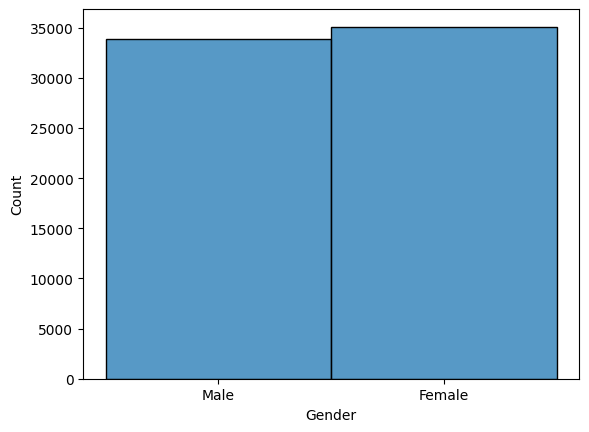

In [33]:
sns.histplot(X_train.Gender)

Так как признак категориальный и у нас всего 2 класса, то заменим male = 1, female = 0

In [34]:
def gender_change(x):
  if x == 'Male':
    return 1
  return 0

In [35]:
X_train.Gender = X_train.Gender.apply(lambda x: gender_change(x))

In [36]:
X_test.Gender = X_test.Gender.apply(lambda x: gender_change(x))

# колонка Age

In [37]:
X_train.Age.describe()

count    68826.000000
mean        40.086595
std         20.327742
min          0.000000
25%         27.000000
50%         40.000000
75%         51.000000
max        612.000000
Name: Age, dtype: float64

612 - какой то аномально большой возраст, давайте посмотрим на рапсределение

<Axes: xlabel='Age', ylabel='Count'>

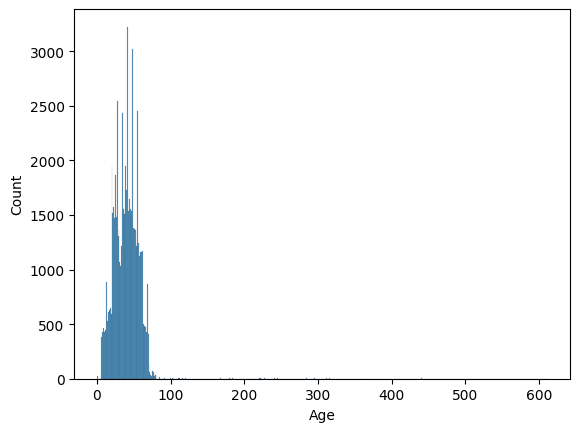

In [38]:
sns.histplot(data=X_train, x = X_train.Age)

очень много выбросов, предлагаю все значения больше 80 заменять на 80, но сначала посмотрим сколько их

In [39]:
X_train[X_train['Age'] > 80]

,Gender,Age,Customer Type,Type of Travel,Class,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Inflight wifi service,Departure/Arrival time convenient,...,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness
90467,1,235.0,Loyal Customer,Business travel,Business,2857.0,161.0,187.0,2.0,2.0,...,3.0,3.0,3.0,3.0,4.0,4.0,5.0,3.0,3.0,3.0
108132,0,296.0,Loyal Customer,Business travel,Business,3577.0,23.0,26.0,2.0,2.0,...,2.0,4.0,3.0,2.0,2.0,2.0,2.0,4.0,2.0,4.0
124597,0,366.0,Loyal Customer,Personal Travel,Eco,500.0,0.0,0.0,2.0,1.0,...,1.0,1.0,1.0,5.0,5.0,2.0,5.0,4.0,5.0,3.0
96498,0,99.0,Loyal Customer,Business travel,Business,436.0,7.0,11.0,2.0,1.0,...,5.0,4.0,4.0,2.0,2.0,2.0,2.0,4.0,2.0,3.0
16704,1,186.0,Loyal Customer,Business travel,Business,2609.0,18.0,12.0,3.0,5.0,...,5.0,5.0,5.0,5.0,3.0,4.0,3.0,2.0,2.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9215,0,312.0,disloyal Customer,Business travel,Business,157.0,0.0,0.0,4.0,4.0,...,1.0,4.0,1.0,1.0,3.0,4.0,5.0,3.0,5.0,1.0
125070,0,85.0,Loyal Customer,Business travel,Business,3156.0,0.0,0.0,3.0,5.0,...,4.0,3.0,3.0,3.0,1.0,4.0,4.0,3.0,3.0,3.0
42616,0,210.0,Loyal Customer,Business travel,Business,481.0,0.0,0.0,4.0,4.0,...,1.0,5.0,5.0,5.0,5.0,5.0,5.0,1.0,5.0,2.0
31007,0,176.0,Loyal Customer,Business travel,Business,2918.0,31.0,30.0,1.0,5.0,...,5.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0


всего то 249 строчки, давайте заменим

In [40]:
def foo(x):
  if x > 80:
    x = 80
  return x

X_train.Age = X_train.Age.apply(lambda x: foo(x))
X_test.Age = X_test.Age.apply(lambda x: foo(x))

In [41]:
X_train.Age.max()

80.0

Данный признак содержит пропуски

In [42]:
X_train.Age.isna().sum()

181

In [43]:
X_train.Age.mode()

0    39.0
Name: Age, dtype: float64

In [44]:
X_train.Age.fillna(39.0, inplace = True)
X_train.Age.isna().sum()

0

теперь для тестовой выборки

In [45]:
X_test.Age.mode()

0    39.0
Name: Age, dtype: float64

In [46]:
X_test.Age.fillna(39.0, inplace = True)
X_test.Age.isna().sum()

0

Изменим тип данных на int

In [47]:
X_train.Age = X_train.Age.apply(lambda x: int(x))
X_test.Age = X_test.Age.apply(lambda x: int(x))

# Рассмотрим колонку Customer Type

Из описания данной колонки выше видно, что тип object и всего 2 уникальных элемента, причем сильно преобладает класс Loyal Customer

In [48]:
X_train['Customer Type'].describe()

count              69007
unique                 2
top       Loyal Customer
freq               56424
Name: Customer Type, dtype: object

In [49]:
X_train['Customer Type'].unique()

array(['Loyal Customer', 'disloyal Customer'], dtype=object)

посмотрим на рапсределение

<Axes: xlabel='Customer Type', ylabel='Count'>

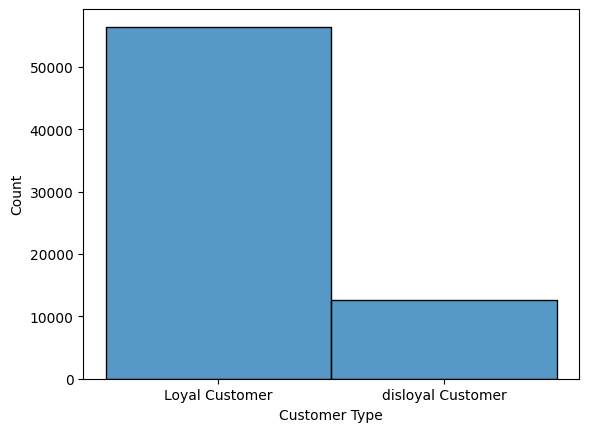

In [50]:
sns.histplot(X_train['Customer Type'])

In [51]:
def Customer_change(x):
  if x == 'disloyal Customer':
    return 0
  return 1

In [52]:
X_train['Customer Type'] = X_train['Customer Type'].apply(lambda x: Customer_change(x))

In [53]:
X_test['Customer Type'] = X_test['Customer Type'].apply(lambda x: Customer_change(x))

# Type of Travel

In [54]:
X_train['Type of Travel'].describe()

count               69007
unique                  2
top       Business travel
freq                47603
Name: Type of Travel, dtype: object

Посмотрим на распределение

<Axes: xlabel='Type of Travel', ylabel='Count'>

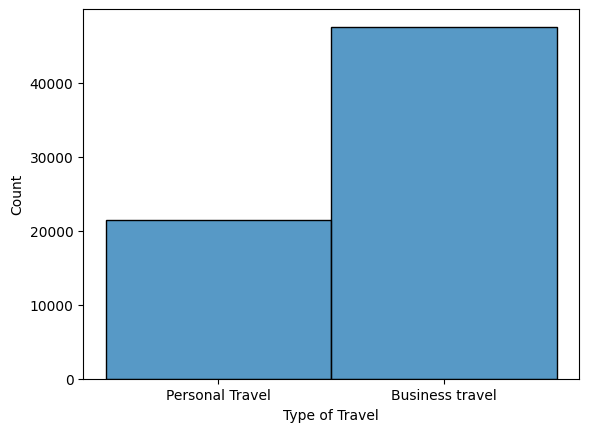

In [55]:
sns.histplot(X_train['Type of Travel'])

In [56]:
def travel_change(x):
  if x == 'Business travel':
    return 1
  return 0

In [57]:
X_train['Type of Travel'] = X_train['Type of Travel'].apply(lambda x: travel_change(x))

In [58]:
X_test['Type of Travel'] = X_test['Type of Travel'].apply(lambda x: travel_change(x))

# Колонка Class

In [59]:
X_train.Class.describe()

count        69007
unique           3
top       Business
freq         33035
Name: Class, dtype: object

In [60]:
X_train.Class.unique()

array(['Eco', 'Business', 'Eco Plus'], dtype=object)

данную колонку преобразуем при помощи one-hot encoding

In [61]:
t = pd.get_dummies(X_train['Class'])
t2 = pd.get_dummies(X_test['Class'])

In [62]:
X_train.shape

(69007, 22)

In [63]:
X_train = X_train.drop(['Class'], axis=1)
X_train = pd.concat([X_train, t], axis = 1)
X_train.shape

(69007, 24)

In [64]:
X_test = X_test.drop(['Class'], axis=1)
X_test = pd.concat([X_test, t2], axis = 1)
X_test.shape

(33990, 24)

# Arrival Delay in Minutes

В данной колонке есть прпуски данных

In [65]:
X_train['Arrival Delay in Minutes'].describe()

count    68746.000000
mean        16.880793
std        106.842239
min          0.000000
25%          0.000000
50%          0.000000
75%         13.000000
max      11760.000000
Name: Arrival Delay in Minutes, dtype: float64

In [66]:
X_train['Arrival Delay in Minutes'].isna().sum()

261

заменим пропуски медианным значением

In [67]:
X_train['Arrival Delay in Minutes'].fillna(X_train['Arrival Delay in Minutes'].median(), inplace = True)

In [68]:
X_train['Arrival Delay in Minutes'].isna().sum()

0

In [69]:
X_test['Arrival Delay in Minutes'].fillna(X_test['Arrival Delay in Minutes'].median(), inplace = True)
X_test['Arrival Delay in Minutes'].isna().sum()

0

# Кодируем target

In [70]:
y_train.unique()

array(['neutral or dissatisfied', 'satisfied'], dtype=object)

In [71]:
def trg_change(x):
  if x == 'satisfied':
    return 1
  return 0

In [72]:
y_train = y_train.apply(lambda x: trg_change(x))
y_test = y_test.apply(lambda x: trg_change(x))

посмотрим описание остальных числовых признаков

Первые 2 признака это задержка(прилета/вылета) в минутах, остальные признаки до cleanliness это различные виды оценок

In [73]:
X_train.iloc[:, 5:].describe()

,Departure Delay in Minutes,Arrival Delay in Minutes,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Business,Eco,Eco Plus
count,69007.000000,69007.000000,69007.000000,69007.000000,69007.000000,69007.000000,69007.000000,69007.000000,69007.000000,69007.000000,69007.000000,69007.000000,69007.000000,69007.000000,69007.000000,69007.000000,69007.000000,69007.000000,69007.000000
mean,15.965351,16.816946,2.739447,3.069065,2.765806,2.985233,3.201965,3.259626,3.441303,3.363079,3.385280,3.356558,3.642399,3.310258,3.648224,3.289884,0.478720,0.449998,0.071283
std,82.545320,106.645028,1.348076,1.555776,1.427595,1.308709,1.357764,1.385688,1.350475,1.370131,1.333313,1.355006,1.228805,1.290879,1.218009,1.343941,0.499551,0.497497,0.257298
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000,0.000000
75%,12.000000,13.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,1.000000,1.000000,0.000000
max,11011.000000,11760.000000,40.000000,35.000000,45.000000,32.000000,45.000000,40.000000,45.000000,40.000000,45.000000,40.000000,40.000000,45.000000,36.000000,45.000000,1.000000,1.000000,1.000000


Посмотрим на корреляцию признаков

In [74]:
df = pd.concat([X_train, y_train], axis=1)

In [76]:
c = df.corr()

Видно, что признаки Gender, Departure Delay in Minutes, Arrival Delay in Minutes практически ни с какими признаками не коррелируют

<Axes: >

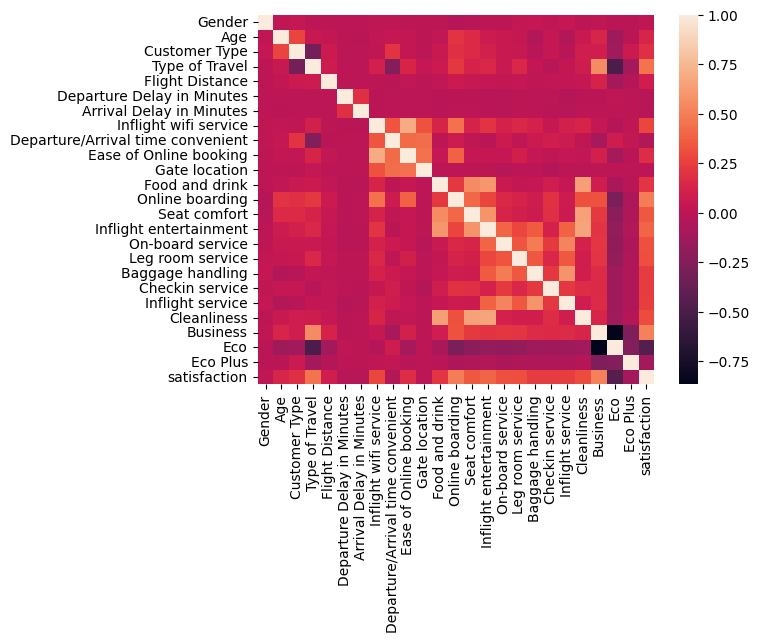

In [77]:
sns.heatmap(c)

In [110]:
from sklearn.linear_model import LogisticRegression as logreg
from sklearn.tree import DecisionTreeClassifier as tree
from sklearn.ensemble import GradientBoostingClassifier as gboost

In [102]:
models = [logreg, tree, gboost]

нормаруем наши данные, для повышение качества модели и чтобы потом можно было интерпретировать веса модели

In [106]:
from sklearn.preprocessing import MinMaxScaler

In [107]:
mx = MinMaxScaler()
mx.fit(X_train)

X_train = pd.DataFrame(mx.transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(mx.transform(X_test), columns = X_train.columns)

Деревья и градиентный бустинг показали одинаково хорошие результаты. Для дальнейшей обработки выберем деревья (подбор гиперпараметров модели)

In [111]:
for elem in models:
  model = elem()
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  print(model)
  if elem == logreg:
    coef = model.coef_
  print(classification_report(y_test, y_pred))
  print("===========================================")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()
              precision    recall  f1-score   support

           0       0.88      0.91      0.89     19267
           1       0.87      0.83      0.85     14723

    accuracy                           0.87     33990
   macro avg       0.87      0.87      0.87     33990
weighted avg       0.87      0.87      0.87     33990

DecisionTreeClassifier()
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     19267
           1       0.94      0.94      0.94     14723

    accuracy                           0.95     33990
   macro avg       0.94      0.94      0.94     33990
weighted avg       0.95      0.95      0.95     33990

GradientBoostingClassifier()
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     19267
           1       0.94      0.92      0.93     14723

    accuracy                           0.94     33990
   macro avg       0.94      0.94      0.94     33990

Попробуем внести некоторые изменения в данные: уберем ненужные признаки. Для этого посмотрим на коэффициенты нашей модели

In [114]:
coef

array([[ 0.03566758, -0.47492192,  1.87535641,  2.57221423,  0.7127396 ,
        -2.44927492, -2.74006599, 13.03782097, -3.44279377, -2.46764365,
        -0.49780127, -0.23159855, 20.2380013 ,  3.84086864,  4.37826706,
        11.40024564,  8.22419255,  4.71144522, 12.40612794,  4.93437388,
         7.48852019, -0.75114651, -1.52836223, -1.6232915 ]])

удалим признаки, у которых веса по модулю меньше 1

In [118]:
coef.shape

(1, 24)

In [123]:
df_new = pd.DataFrame()

In [124]:
mas = []
for idx, col in enumerate(X_train.columns):
  if abs(coef[0][idx]) >= 1:
    t = X_train[f'{col}']
    df_new = pd.concat([df_new, t], axis = 1)
  else:
    mas.append(col)

Признаки с наименьшим весом

In [125]:
mas

['Gender',
 'Age',
 'Flight Distance',
 'Gate location',
 'Food and drink',
 'Business']

In [126]:
X_train_new = X_train.drop(columns = mas)
X_test_new = X_test.drop(columns = mas)

снова обучим и предскажем

In [128]:
for elem in models:
  model = elem()
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  print(model)
  if elem == logreg:
    coef = model.coef_
  print(classification_report(y_test, y_pred))
  print("===========================================")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()
              precision    recall  f1-score   support

           0       0.87      0.91      0.89     19267
           1       0.87      0.83      0.85     14723

    accuracy                           0.87     33990
   macro avg       0.87      0.87      0.87     33990
weighted avg       0.87      0.87      0.87     33990

DecisionTreeClassifier()
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     19267
           1       0.93      0.93      0.93     14723

    accuracy                           0.94     33990
   macro avg       0.94      0.94      0.94     33990
weighted avg       0.94      0.94      0.94     33990

GradientBoostingClassifier()
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     19267
           1       0.94      0.91      0.93     14723

    accuracy                           0.94     33990
   macro avg       0.94      0.94      0.94     33990

Прибавления качества модели не заметил, так что оставим эти признаки

попробуем подобрать гиперпараметры деревьев

In [130]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [138]:
criterion = ['gini', 'entropy', 'log_loss']
max_depth = [2, 5, 10, 15, 30, 50]

In [143]:
res = []

In [144]:
for loss in criterion:
  print(loss)
  for depth in max_depth:
    model = tree(criterion=loss, max_depth=depth)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    res.append((precision_score(y_pred, y_test), recall_score(y_pred, y_test)))
    print((precision_score(y_pred, y_test), recall_score(y_pred, y_test)))
  print("---------------------------------------")

gini
(0.8399103443591659, 0.8313836224283986)
(0.8696597160904707, 0.8657786192440328)
(0.8787611220539292, 0.8968529044780258)
(0.8898322352781363, 0.9284246332648288)
(0.9119744617265503, 0.9512575274530641)
(0.9299055898933641, 0.947736397618718)
(0.9343883719350676, 0.932804448060754)
---------------------------------------
entropy
(0.8399103443591659, 0.8313836224283986)
(0.8696597160904707, 0.8657786192440328)
(0.8763159682130001, 0.9002232765838682)
(0.885621136996536, 0.9411042944785276)
(0.9164572437682538, 0.9520214492344599)
(0.9252190450315833, 0.9553264604810997)
(0.9349996603952999, 0.933541299335413)
---------------------------------------
log_loss
(0.8399103443591659, 0.8313836224283986)
(0.8696597160904707, 0.8657786192440328)
(0.8762480472729742, 0.9000279056788056)
(0.885621136996536, 0.9411722246282662)
(0.9162534809481763, 0.9519441112130407)
(0.9257624125517897, 0.9554854539081669)
(0.9351355022753515, 0.9326017747070379)
---------------------------------------


подбор гиперпараметров также особых улучшений не дал

сохраним модель на дефолтных параметрах

In [145]:
model = tree()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [154]:
import pickle

with open('/content/gdrive/MyDrive/ML-сервис/model.pickle', 'wb') as f:
    pickle.dump(model, f)

#а так модель можно загрузить из файла:
#with open('model.pickle', 'rb') as f:
#    model = pickle.load(f)